# 02. Data Engineering

In this notebook, we will transform the data to fit the format required for our model and we will create new features to add valuable info to it. 

To start this notebook we will use the DataFrame we generated in Cleaning_Data.

## Loading libraries and data

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
import collections
import seaborn as sns
from functools import reduce
from scipy import stats
%matplotlib inline
plt.style.use('ggplot')

In [29]:
reves=pd.read_pickle("./data/cleaned_reves_df.pkl")

In [30]:
reves.head(2)

,belongs_to_collection,budget,genres,original_language,production_companies,revenue,runtime,title,keywords,release_year,release_month,release_weekday,cast_names,cast_gender,cast_order,Directors,Producers,Screenplayers
0,Toy Story Collection,30000000.0,"[Animation, Comedy, Family]",en,[Pixar Animation Studios],373554033.0,81.0,Toy Story,"[jealousy, toy, boy, friendship, friends, riva...",1995.0,10.0,0.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 2, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",[John Lasseter],"[Bonnie Arnold, Ralph Guggenheim]","[Joss Whedon, Andrew Stanton, Joel Cohen, Alec..."
1,NaN,65000000.0,"[Adventure, Fantasy, Family]",en,"[TriStar Pictures, Teitler Film, Interscope Co...",262797249.0,104.0,Jumanji,"[board game, disappearance, based on children'...",1995.0,12.0,4.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[2, 2, 1, 0, 1, 1, 2, 1, 0, 1, 2, 1, 2, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Joe Johnston],"[Scott Kroopf, William Teitler]","[Jonathan Hensleigh, Greg Taylor, Jim Strain]"


## Let's perform some data transformation

#### Belongs to collection

As we explained in the first notebook, what we really need from this column is to know whether a movie belongs to a series or a collection or not. The name of the collection by itself woulnd't add any knowledge to our model. That's why we are going to overwrite this column with 2 possible values:
- 1 for movies that belong to a collection
- 0 for movies that don't

In [4]:
reves["belongs_to_collection"] = reves["belongs_to_collection"].apply(lambda x: 1 if type(x)==str else 0)

#### Genres

From "Genres" we are going to create the following columns that will add more valuable an actionable information to reves:
- **Genres count:** We think that the number of genres associated to a movie could be related to the complexity of the plot, and eventually to the movie's potential revenue.
- **Dummy genres**: we will transform a list of N genres to N dummy columns that will contain 1 or 0 values according to whether the movie has that genre associated (1) or not (0).

In [5]:
def get_uniques(sequence):
    #from ast import literal_eval
    #sequence=sequence.fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
    counter=[]
    for line in sequence:
        counter.append(line)
        flat_list=[item for sublist in sequence for item in sublist]
        for sublist in sequence:
            for item in sublist:
                flat_list.append(item)
        counter=list(set(flat_list))
        
        return counter

In [6]:
genres=get_uniques(reves["genres"])
print(genres)

['Comedy', 'Romance', 'Action', 'Crime', 'Mystery', 'Adventure', 'Music', 'History', 'Horror', 'Documentary', 'Science Fiction', 'Foreign', 'Western', 'TV Movie', 'Fantasy', 'Thriller', 'War', 'Animation', 'Family', 'Drama']


In [7]:
def word_to_dummy(word,ref_column):
    word_list=[]
    for line in ref_column:
        value=0
        for element in line:
            if element==str(word):
                value+=1
            else:
                value+=0
        word_list.append(value)
    return word_list

In [8]:
for line in genres:
    reves[line]=word_to_dummy(line,reves["genres"])

In [9]:
reves.columns

Index(['belongs_to_collection', 'budget', 'genres', 'original_language',
       'production_companies', 'revenue', 'runtime', 'title', 'keywords',
       'release_year', 'release_month', 'release_weekday', 'cast_names',
       'cast_gender', 'Directors', 'Producers', 'Screenplayers', 'Comedy',
       'Romance', 'Action', 'Crime', 'Mystery', 'Adventure', 'Music',
       'History', 'Horror', 'Documentary', 'Science Fiction', 'Foreign',
       'Western', 'TV Movie', 'Fantasy', 'Thriller', 'War', 'Animation',
       'Family', 'Drama'],
      dtype='object')

Now we are creating a column with the number of genres per movie, as we think that it can be related to movie revenue as it can explain the complexity of the movie's synopsis. We will write a function because we will use it later for other purposes.

In [10]:
def lenght_column(column):
    column_lenght=[]
    for line in reves[column]:
        column_lenght.append(len(line))
    return column_lenght

In [11]:
reves["Genres_count"]=lenght_column("genres")

In [12]:
reves.head()

,belongs_to_collection,budget,genres,original_language,production_companies,revenue,runtime,title,keywords,release_year,...,Foreign,Western,TV Movie,Fantasy,Thriller,War,Animation,Family,Drama,Genres_count
0,1,30000000.0,"[Animation, Comedy, Family]",en,[Pixar Animation Studios],373554033.0,81.0,Toy Story,"[jealousy, toy, boy, friendship, friends, riva...",1995.0,...,0,0,0,0,0,0,1,1,0,3
1,0,65000000.0,"[Adventure, Fantasy, Family]",en,"[TriStar Pictures, Teitler Film, Interscope Co...",262797249.0,104.0,Jumanji,"[board game, disappearance, based on children'...",1995.0,...,0,0,0,1,0,0,0,1,0,3
2,0,16000000.0,"[Comedy, Drama, Romance]",en,[Twentieth Century Fox Film Corporation],81452156.0,127.0,Waiting to Exhale,"[based on novel, interracial relationship, sin...",1995.0,...,0,0,0,0,0,0,0,0,1,3
3,1,NaN,[Comedy],en,"[Sandollar Productions, Touchstone Pictures]",76578911.0,106.0,Father of the Bride Part II,"[baby, midlife crisis, confidence, aging, daug...",1995.0,...,0,0,0,0,0,0,0,0,0,1
4,0,60000000.0,"[Action, Crime, Drama, Thriller]",en,"[Regency Enterprises, Forward Pass, Warner Bros.]",187436818.0,170.0,Heat,"[robbery, detective, bank, obsession, chase, s...",1995.0,...,0,0,0,0,1,0,0,0,1,4


In [13]:
## qué funcionan mejor: las pelis simples o las pelis con tramas más complicadas? Scatter plot entre genres lenght y revenue.
## Para ver posible relación lineal?

 
 
#### Original Language

As we stablished in the preliminar exploration, we will transform this feature into a categorical variable with 2 possible values:

- English = 1
- Not english = 0

In [14]:
reves["original_language"] = reves["original_language"].apply(lambda x: 1 if x=="en" else 0)

  
#### Production company

In [15]:
reves["production_companies_count"]=lenght_column("production_companies")

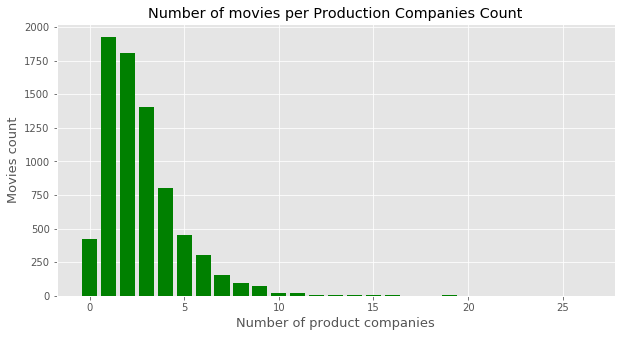

In [16]:
plt.figure(figsize = (10, 5))
plt.bar(reves.groupby("production_companies_count").count()["title"].index,
        reves.groupby("production_companies_count").count()["title"].values,color="green")
plt.ylabel("Movies count", fontsize = 13)
plt.xlabel("Number of product companies", fontsize = 13)
plt.title("Number of movies per Production Companies Count");
plt.show()

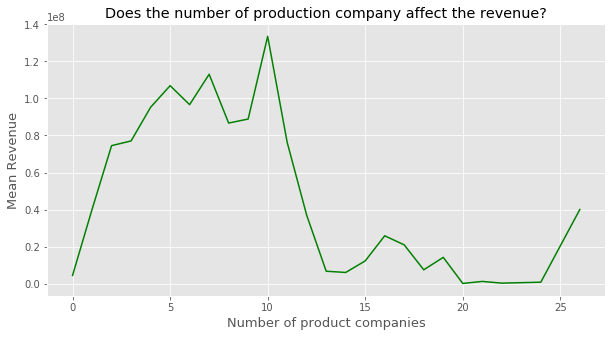

In [17]:
plt.figure(figsize = (10, 5))
plt.plot(reves.groupby("production_companies_count").mean()["revenue"], color="green")
plt.ylabel("Mean Revenue", fontsize = 13)
plt.xlabel("Number of product companies", fontsize = 13)
plt.title("Does the number of production company affect the revenue?");

In [18]:
## el numero de productoras tiene relación lineal con el revenue??? ¿A más productoras, más revenue?

In [19]:
## clusterización de productores. En función de most profitable. Para calcular el most profitable...

#mean revenue por combinacion de productoras?
#mean revenue por unique production company? ¿Asignamos el revenue del 

In [20]:
reves["production_companies"]

0                               [Pixar Animation Studios]
1       [TriStar Pictures, Teitler Film, Interscope Co...
2                [Twentieth Century Fox Film Corporation]
3            [Sandollar Productions, Touchstone Pictures]
4       [Regency Enterprises, Forward Pass, Warner Bros.]
5       [Universal Pictures, Imperial Entertainment, S...
6                       [United Artists, Eon Productions]
7          [Columbia Pictures, Castle Rock Entertainment]
8       [Universal Pictures, Amblin Entertainment, Amb...
9       [Hollywood Pictures, Cinergi Pictures Entertai...
10      [Le Studio Canal+, Laurence Mark Productions, ...
11      [Universal Pictures, Légende Entreprises, Syal...
12      [Columbia Pictures Corporation, Mirage Enterpr...
13                          [Miramax Films, A Band Apart]
14      [O Entertainment, Warner Bros., Morgan Creek P...
15                                    [Columbia Pictures]
16              [Jersey Films, Metro-Goldwyn-Mayer (MGM)]
17      [Silve


#### Cast

We are going to extract the following information from cast column:

- Number of characters/actores.
- For each of the 4 main actors (ordered by "order"):
    - Name
    - Genre

In [21]:
## numero de actores/personajes. Puede, al igual que numero de géneros, explicar una trama más complicada. 
## comparar con gráfica de géneros a ver si sacamos la misma conclusión sobre la complejidad de la trama

# de los 4 primeros actores, nombre y género. En tuplas?? 

#clusterizar actores. En función de most profitable. 

#Para clusterizar directores, keywords.... nos quedamos con min(), no mean().   
#Los elementos de estas listas no tienen por qué estar ordenados. 
#El primer director de la lista no tiene que ser el director más importante. 
#Nos quedamos con el mejor, o el que más relevancia en la lista de mostprofitable tenga

In [22]:
reves["number_of_characters"]=lenght_column("cast_names")

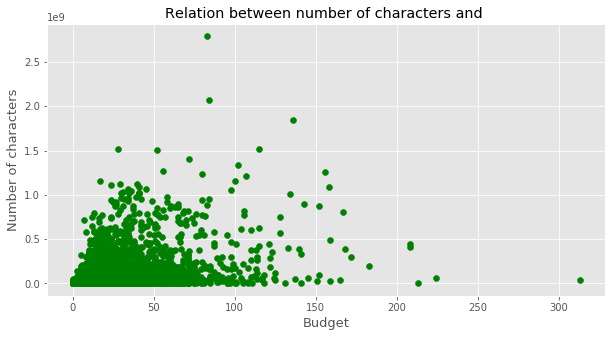

In [23]:
plt.figure(figsize = (10, 5))

fig = plt.scatter(x = reves["number_of_characters"], y = reves["revenue"],color="green")

plt.ylabel("Number of characters", fontsize = 13)
plt.xlabel("Budget", fontsize = 13)
plt.title("Relation between number of characters and ")

plt.show()

In [24]:
### Al clusterizar meteremos al modelo 
    #nº de actores(len)
    #puntuación total de los actores (del clustering) --> crear función que haga la suma a partir del ranking, introduciendo una lista         con los nombres de los actores. 
              #def(lista)
                   #return puntuacion
    #género actor 1
    #género actor 2

In [31]:
reves.head(3)

,belongs_to_collection,budget,genres,original_language,production_companies,revenue,runtime,title,keywords,release_year,release_month,release_weekday,cast_names,cast_gender,cast_order,Directors,Producers,Screenplayers
0,Toy Story Collection,30000000.0,"[Animation, Comedy, Family]",en,[Pixar Animation Studios],373554033.0,81.0,Toy Story,"[jealousy, toy, boy, friendship, friends, riva...",1995.0,10.0,0.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 2, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",[John Lasseter],"[Bonnie Arnold, Ralph Guggenheim]","[Joss Whedon, Andrew Stanton, Joel Cohen, Alec..."
1,NaN,65000000.0,"[Adventure, Fantasy, Family]",en,"[TriStar Pictures, Teitler Film, Interscope Co...",262797249.0,104.0,Jumanji,"[board game, disappearance, based on children'...",1995.0,12.0,4.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[2, 2, 1, 0, 1, 1, 2, 1, 0, 1, 2, 1, 2, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Joe Johnston],"[Scott Kroopf, William Teitler]","[Jonathan Hensleigh, Greg Taylor, Jim Strain]"
2,NaN,16000000.0,"[Comedy, Drama, Romance]",en,[Twentieth Century Fox Film Corporation],81452156.0,127.0,Waiting to Exhale,"[based on novel, interracial relationship, sin...",1995.0,12.0,4.0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[1, 1, 1, 1, 2, 2, 2, 2, 2, 2]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",[Forest Whitaker],"[Ronald Bass, Ezra Swerdlow, Deborah Schindler...","[Ronald Bass, Terry McMillan]"


In [ ]:
#crear un subset sólo con title, revenue, cast_names_ cast_gender y cast_order. Para hacer el ranking en un dataframe aparte 
#y volver a asigar valores en un merge por "title"
    #CAST 1 NAME
    #CAST 1 GENRE
    #CAST 2 NAME
    #CAST 2 GENRE
    #CAST 3 NAME
    #CAST 3 GENRE
    #CAST 4 NAME
    #CAST 4 GENRE
#queremos asociar "Cast Name" con "cast gender" y "Cast Order"
#para cada movie,para cada actor, filtrar aquellas cuyo order sea mayor que 4

for movie in reves:
    

In [40]:
cast=reves[["cast_names","cast_gender","cast_order","revenue","title"]]

In [48]:
cast.shape

(7537, 5)

In [66]:
def combiner(dataframe):
    cast_name=[]
    cast_gender=[]
    cast_order=[]
    revenue=[]
    title=[]
    for element in dataframe:
        cast_name.append(cast["cast_name"])
        cast_gender.append(cast["cast_gender"])
        cast_order.append(cast["cast_order"])
        revenue.append(cast["revenue"])
        title.append(cast["title"])

    
    return (cast_name,cast_order,cast_gender,revenue,title)

tidy_cast=list(map(combiner,cast))
tidy_cast

KeyError: 'cast_name'

In [47]:
general_cast=[]
for movie in cast:
    for element in movie:
        general_cast.append(["cast_names","cast_gender","cast_order","revenue","title"])

general_cast

[['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_names', 'cast_gender', 'cast_order', 'revenue', 'title'],
 ['cast_na

#### Crew